In [2]:
import math
import numpy as np
import torch
T = 20
L = 1000
N = 100
np.random.seed(2)
x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

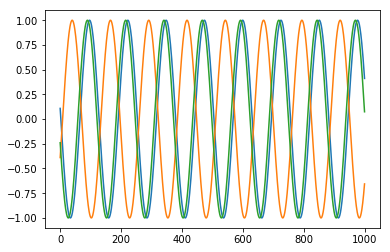

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(3):
    plt.plot(data[i])

In [4]:
import pdb

In [17]:
import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 1).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 1).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]
#             pdb.set_trace()
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]
#         pdb.set_trace()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [21]:
class Sequence(nn.Module):
    def __init__(self, input_dim):
        super(Sequence, self).__init__()
        self.hidden_dim = 51
        self.input_dim = input_dim
        self.lstm1 = nn.LSTMCell(input_dim, self.hidden_dim)
        self.lstm2 = nn.LSTMCell(self.hidden_dim, input_dim)
        self.hidden2out = nn.Linear(input_dim, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), self.hidden_dim).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), self.hidden_dim).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), self.input_dim).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), self.input_dim).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
#             pdb.set_trace()
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             out = self.hidden2out(c_t2)
            out = c_t2
            outputs += [out]
#             pdb.set_trace()
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             out = self.hidden2out(c_t2)
            out = c_t2
            outputs += [out]
#         pdb.set_trace()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [36]:
# set ramdom seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)
# build the model
seq = Sequence(1)
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters())
# optimizer = optim.RMSprop(seq.parameters(), lr = 1e-2)
#begin to train
#     plt.savefig('predict%d.pdf'%i)
#     plt.close()

('STEP: ', 0)
('loss:', 1.0905448068473174)
('loss:', 0.82649840505248329)
('loss:', 0.74225894637092038)
('loss:', 0.46692668109953905)
('loss:', 0.33128949650860623)
('loss:', 0.23602619515900436)
('loss:', 0.14125912909412025)
('loss:', 0.085153044820227827)
('loss:', 0.054104216215633875)
('loss:', 0.040030814690416631)
('loss:', 0.034845401468766996)
('loss:', 0.029875946138902241)
('loss:', 0.027020025821771189)
('loss:', 0.024940579024830406)
('loss:', 0.023600123478278941)
('loss:', 0.019104090944550518)
('loss:', 0.013380182114829694)
('loss:', 0.011366279106457707)
('loss:', 0.0098356749202799919)
('loss:', 0.0089371478527572323)
('test loss:', 0.008479531149476572)


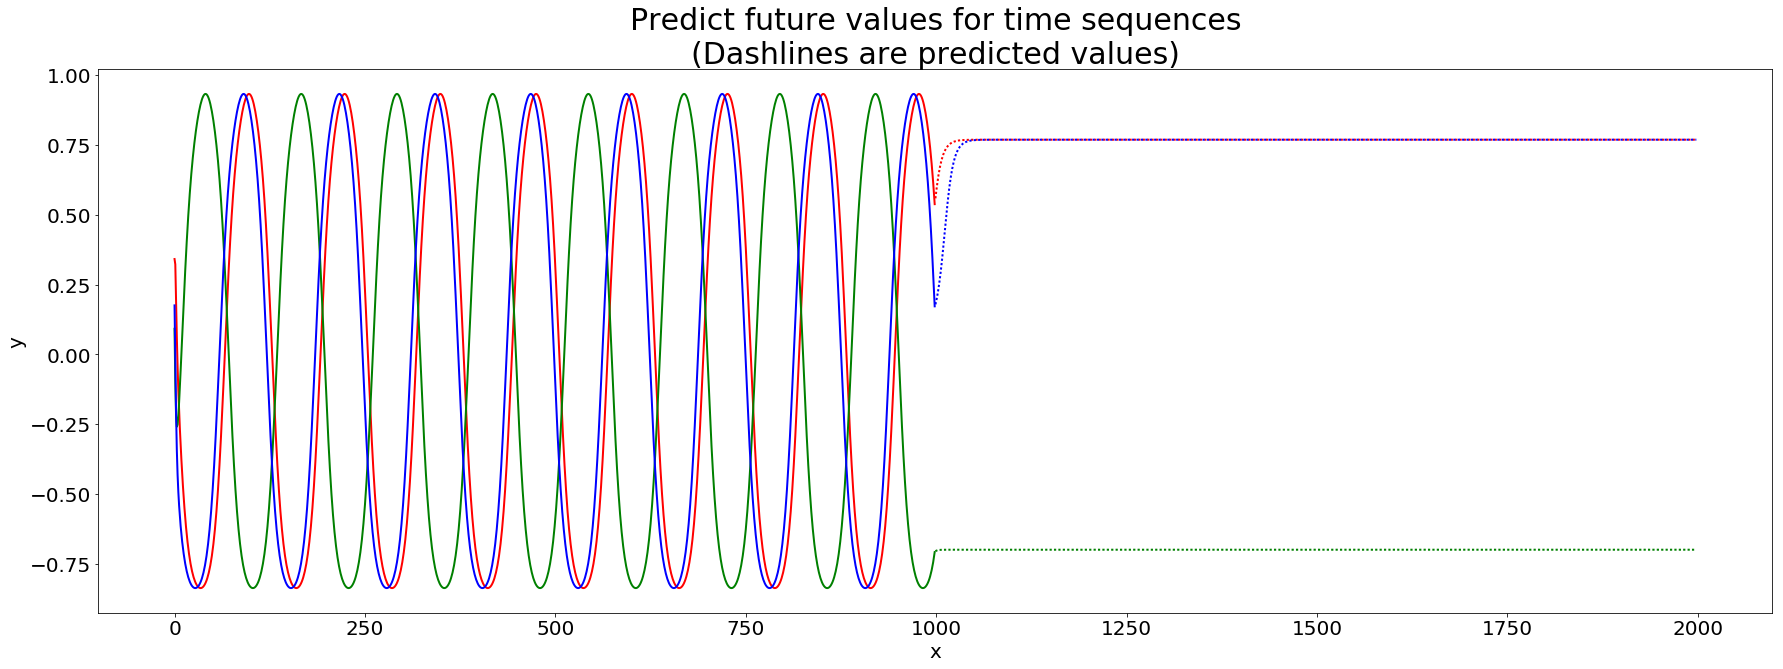

In [37]:
for i in range(1):
    print('STEP: ', i)  
    def closure():
        optimizer.zero_grad()
        out = seq(input)
#         pdb.set_trace()
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict
    future = 1000
    pred = seq(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30) 
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')

In [43]:
seq.lstm1.bias_hh.size()

torch.Size([204])

In [ ]:
plt.figure(figsize=(30,10))
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')